In [144]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

train1 = pd.read_csv('train_dataset01.csv')
train2 = pd.read_csv('train_dataset02.csv')
test = pd.read_csv('test_dataset.csv')

In [145]:
train2.head()

,DATETIME,LEVEL_T1,LEVEL_T2,LEVEL_T3,LEVEL_T4,LEVEL_T5,LEVEL_T6,LEVEL_T7,PRESSURE_J280,PRESSURE_J269,...,STATUS_PU4,STATUS_PU5,STATUS_PU6,STATUS_PU7,STATUS_PU8,STATUS_PU9,STATUS_PU10,STATUS_PU11,STATUS_V2,ATT_FLAG
0,2016-02-04 05:00:00,1.40,3.81,4.96,4.04,4.5,5.02,2.71,2.98,35.33,...,False,False,False,True,True,False,True,False,True,False
1,2016-02-04 05:15:00,1.45,3.89,4.91,4.16,4.5,5.11,2.94,2.98,35.36,...,False,False,False,True,True,False,True,False,True,False
2,2016-02-04 05:30:00,1.49,3.97,4.85,4.29,4.5,5.20,3.17,2.98,35.39,...,False,False,False,True,True,False,True,False,True,False
3,2016-02-04 05:45:00,1.53,4.05,4.80,4.42,4.5,5.30,3.40,2.98,35.41,...,False,False,False,True,True,False,True,False,True,False
4,2016-02-04 06:00:00,1.57,4.12,4.74,4.55,4.5,5.39,3.63,2.98,35.32,...,False,False,False,False,True,False,True,False,True,False


In [146]:
# Calculate p-value for every obs
def make_p_values(data, means, stds):
    """
    Calculate p-value for all obs for all numeric 
    features
    """
    numeric_cols = data.select_dtypes(include="float64").columns
    new_cols = []
    for col in numeric_cols:
        new_col = col + "_p"
        
        # Calculate p-values
        data[new_col] = data[col].apply(stats.norm.cdf, 
                                        args=(means[col], std[col]))
        
        # Make values between 0 and 0.5
        data[new_col] = np.where(data[new_col] <= 0.5, data[new_col], 1 - data[new_col])
        new_cols.append(new_col)

    return new_cols
        

In [147]:
# Vote anomalies from p-values
def create_votes(data, p_cols, threshold):
    """
    For each p-value column, add 1 vote if p-value below threshold
    Votes decide whether an obs is an anomaly
    """
    temp = data[test_p_cols] < threshold
    data["votes"] = temp.sum(axis=1)


In [148]:
# Learn mean and std from no attack data
no_attacks = train2[~train2.ATT_FLAG]
means = no_attacks.mean()
stds = no_attacks.std()

# Make p-value columns
test_p_cols = make_p_values(test, means, stds)

In [153]:
# Make vote column
create_votes(test, test_p_cols, 0.03)


In [165]:
# Predict ATT_FLAG in test
min_vote = 8
out = test[["DATETIME"]].copy()
out["ATT_FLAG"] = np.where(test["votes"] >= min_vote, 1, 0)


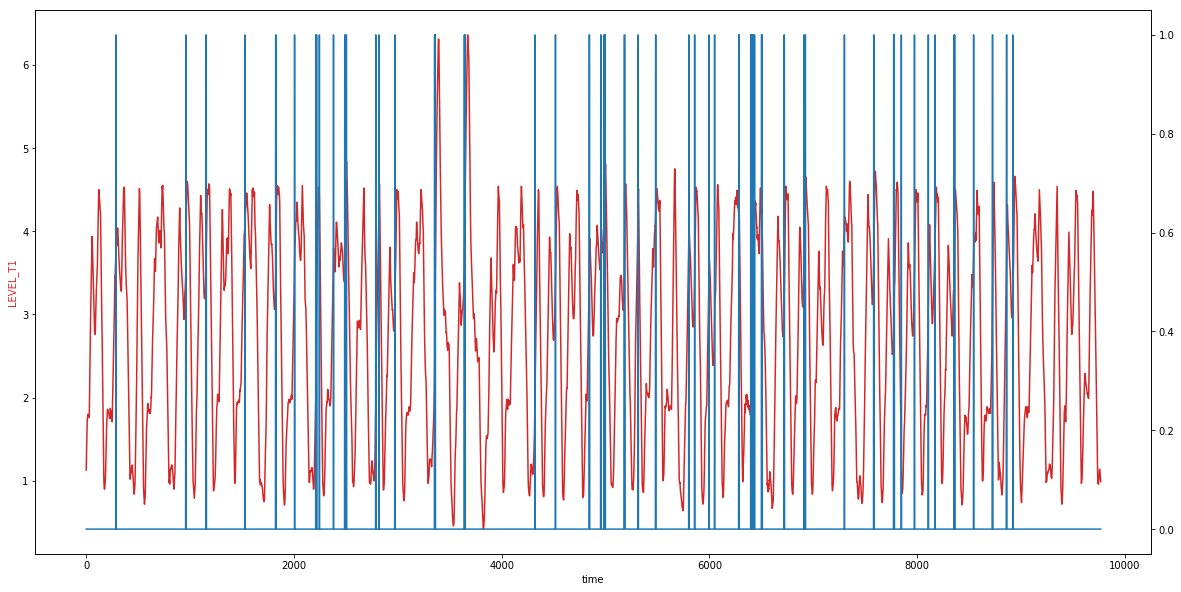

In [166]:
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('LEVEL_T1', color=color)
ax1.plot(test['LEVEL_T1'], color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(out['ATT_FLAG'], color=color)

plt.show()